In [25]:
# パラメータ
d = 5
n = (d + 1) / 2  # n = 3
n = int(n)

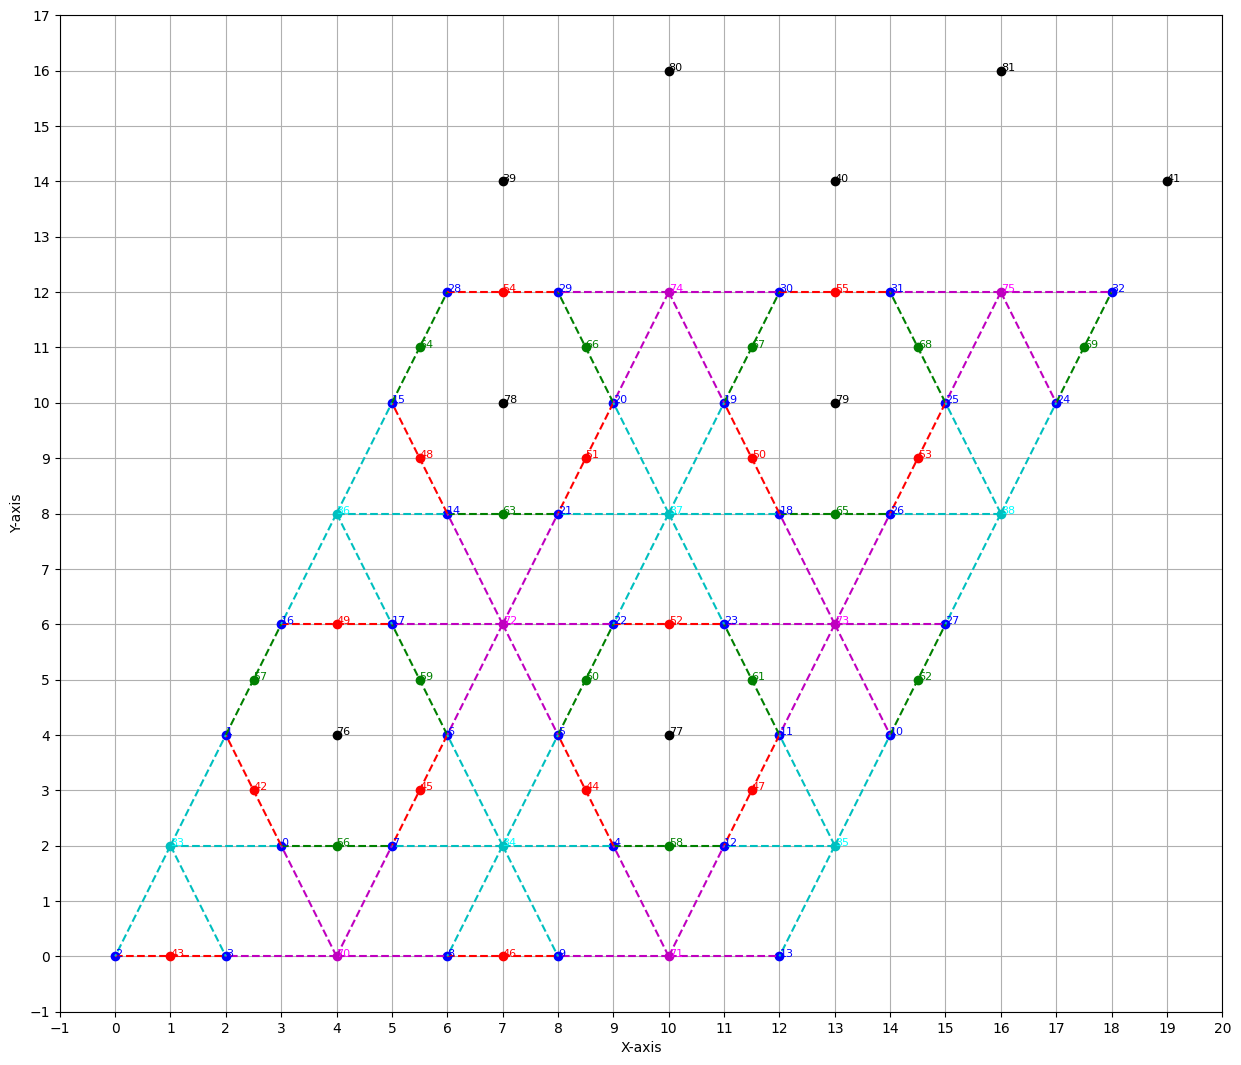

In [26]:
import math
import matplotlib.pyplot as plt


shift_dx, shift_dy = 6, 0
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
paired_direction_sets = [
    [(2, 0), (1, 2)],
    [(-1, 2), (-2, 0)],
    [(-1, -2), (1, -2)]
]

data_qubits = []
ancilla_qubits = []
direction_map = []  # 各ancilla生成毎 (最初のブロック)の(direction,生成data qubit index)記録

base_x, base_y = 1, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
current_data_index = 0

# --- 最初のブロック(ancilla + data生成) ---
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        if step == 0:
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:
            filtered_directions = directions

        if point_index == len(initial_base_points) - 1:
            if step == n - 1:
                filtered_directions = [(-1, -2)]
            else:
                filtered_directions = [(-1, -2), (1, -2)]

        # Ancilla登録
        ancilla_qubits.append((base_x_current, base_y_current))
        temp_dir_record = []
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))
            temp_dir_record.append((dx, dy, current_data_index))
            current_data_index += 1

        direction_map.append(temp_dir_record)
        base_x_current += shift_dx
        base_y_current += shift_dy

# data, ancilla辞書の初期構築
data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

# green_X_face: 最初のブロックで生成されたancillaについてdirection_mapから取得
green_X_face = {}
for i, record in enumerate(direction_map):
    ancilla_index = ancilla_qubit_dict_start + i
    green_X_face[ancilla_index] = [(dx, dy, di) for (dx, dy, di) in record]

# blue_Z_edge生成
blue_Z_edge = {}
for ancilla_num, record in enumerate(direction_map):
    for pair_dirs in paired_direction_sets:
        indices_found = []
        for (dx,dy) in pair_dirs:
            for (rdx,rdy,di) in record:
                if rdx == dx and rdy == dy:
                    indices_found.append(di)
                    break
        if len(indices_found) == 2:
            B, Bp = indices_found
            x1,y1 = data_qubit_dict[B]
            x2,y2 = data_qubit_dict[Bp]
            mid_x = (x1+x2)/2.0
            mid_y = (y1+y2)/2.0
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (mid_x, mid_y)
            blue_Z_edge[A_index] = (B,Bp)

# green_X_edge生成 (最初のブロック)
green_X_edge = {}
num_first_block_ancillas = len(initial_base_points)*n
first_block_ancillas = ancilla_qubits[:num_first_block_ancillas]

for i in range(num_first_block_ancillas):
    for j in range(i+1, num_first_block_ancillas):
        x1,y1 = first_block_ancillas[i]
        x2,y2 = first_block_ancillas[j]
        dx = x2 - x1
        dy = y2 - y1
        dist = math.sqrt(dx*dx + dy*dy)
        if abs(dist - 6) < 1e-9 or abs(dist - 3*math.sqrt(5)) < 1e-9:
            selected_data = []
            for d_i,(xd,yd) in data_qubit_dict.items():
                if (xd == x1 and yd == y1) or (xd == x2 and yd == y2):
                    continue
                if abs(dx*(yd - y1) - dy*(xd - x1)) < 1e-9:
                    if min(x1,x2) <= xd <= max(x1,x2) and min(y1,y2) <= yd <= max(y1,y2):
                        selected_data.append(d_i)
            if len(selected_data) == 2:
                B,Bp = selected_data
                mid_x = (x1+x2)/2.0
                mid_y = (y1+y2)/2.0
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (mid_x, mid_y)
                green_X_edge[A_index] = (B,Bp)

# ===== 重複アンシラ削除 =====
ancilla_start_index = ancilla_qubit_dict_start
ancilla_indices = [idx for idx in all_qubits_dict if idx >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}

for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        duplicates[A] = coord_to_ancilla_index[coord]

for A in list(blue_Z_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in blue_Z_edge:
            blue_Z_edge[new_A] = blue_Z_edge[A]
        del blue_Z_edge[A]

for A in list(green_X_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in green_X_edge:
            green_X_edge[new_A] = green_X_edge[A]
        del green_X_edge[A]

for A in duplicates.keys():
    del all_qubits_dict[A]

# (4,0,n)
base_sets_400n = [
    (4,0,n),
]

before_400n_count = len(all_qubits_dict)
for (bx, by, steps) in base_sets_400n:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            base_x_current += shift_dx
            base_y_current += shift_dy

after_400n_count = len(all_qubits_dict)
added_ancillas_400n = [idx for idx in range(before_400n_count, after_400n_count)]

# blue_Z_face作成 (4,0,n)で生成されたアンシラのみ対象)
blue_Z_face = {}
for A_index in added_ancillas_400n:
    ax, ay = all_qubits_dict[A_index]
    found_list = []
    for (dx, dy) in directions:
        tx, ty = ax + dx, ay + dy
        for di,(xd,yd) in data_qubit_dict.items():
            if xd == tx and yd == ty:
                found_list.append(((dx,dy), di))
                break
    if len(found_list) > 0:
        blue_Z_face[A_index] = found_list  # [(direction, data_qubit), ...]

# (4,4,n)処理
base_sets_44n = [
    (4,4,n),
]

for (bx, by, steps) in base_sets_44n:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            base_x_current += shift_dx
            base_y_current += shift_dy

ancilla_qubit_dict = {k: v for k, v in all_qubits_dict.items() if k >= ancilla_qubit_dict_start}


###############################
# 並び替え処理
###############################
six_dir_order = [(-1,-2),(2,0),(-1,2),(1,-2),(1,2),(-2,0)]
green_4_dir_order_1 = [(1,-2),(2,0),(-1,-2),(1,2)]
green_4_dir_order_2 = [(-1,-2),(1,2),(-2,0),(-1,2)]
blue_4_dir_order_1 = [(-2,0),(-1,2),(2,0),(1,2)]
blue_4_dir_order_2 = [(-1,-2),(-2,0),(1,-2),(2,0)]

def reorder_face(face_dict, face_name):
    for A, lst in face_dict.items():
        if face_name == 'green_X_face':
            # lst = [(dx,dy,di), ...]
            dir_data_map = { (dx,dy): di for (dx,dy,di) in lst }
            directions_found = list(dir_data_map.keys())
        elif face_name == 'blue_Z_face':
            # lst = [((dx,dy), di), ...]
            dir_data_map = { d:di for (d,di) in lst }
            directions_found = list(dir_data_map.keys())
        else:
            # green_X_edgeなど
            # data qubitのみ
            continue

        count = len(directions_found)

        if count == 6:
            ordered = []
            for d in six_dir_order:
                if d in dir_data_map:
                    ordered.append(dir_data_map[d])
            face_dict[A] = ordered
        elif count == 4:
            if face_name == 'green_X_face':
                if all(d in dir_data_map for d in green_4_dir_order_1):
                    ordered = [dir_data_map[d] for d in green_4_dir_order_1]
                elif all(d in dir_data_map for d in green_4_dir_order_2):
                    ordered = [dir_data_map[d] for d in green_4_dir_order_2]
                else:
                    ordered = [di for di in dir_data_map.values()]
                face_dict[A] = ordered
            elif face_name == 'blue_Z_face':
                if all(d in dir_data_map for d in blue_4_dir_order_1):
                    ordered = [dir_data_map[d] for d in blue_4_dir_order_1]
                elif all(d in dir_data_map for d in blue_4_dir_order_2):
                    ordered = [dir_data_map[d] for d in blue_4_dir_order_2]
                else:
                    ordered = [di for di in dir_data_map.values()]
                face_dict[A] = ordered
        else:
            # 2個以下の場合green_X_faceは要らないため後で削除
            # blue_Z_faceは指定なし(2個以下もOKならそのまま)
            if face_name == 'green_X_face':
                # dataのみ抽出(だが2個以下は後で削除するためこのままでもOK)
                face_dict[A] = [di for (dx,dy,di) in lst]
            elif face_name == 'blue_Z_face':
                face_dict[A] = [di for (d,di) in lst]

# 並び替え
reorder_face(green_X_face, 'green_X_face')
reorder_face(blue_Z_face, 'blue_Z_face')

# green_X_faceについてdata qubitが2個以下のものは要らない
green_X_face = {A: v for A,v in green_X_face.items() if len(v) > 2}

# blue_Z_faceは特に指定なし（必要なら同様にフィルタリング可能）

# プロット
# プロット
fig, ax = plt.subplots(figsize=(15, 15))  # サイズを幅15、高さ15に設定

# data_qubitsは青
for i,(x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(i), color='blue', fontsize=8)

ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]

# 通常アンシラ(黒)
normal_ancillas = set(ancilla_indices) - set(blue_Z_edge.keys()) - set(green_X_edge.keys()) - set(blue_Z_face.keys()) - set(green_X_face.keys())
for A_index in normal_ancillas:
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ko')
    ax.text(xA, yA, str(A_index), color='black', fontsize=8)

# blue_Z_edge(赤)
for A_index,(B,Bp) in blue_Z_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ro')
    ax.text(xA, yA, str(A_index), color='red', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'r--')

# green_X_edge(緑)
for A_index,datapair in green_X_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'go')
    ax.text(xA, yA, str(A_index), color='green', fontsize=8)
    if len(datapair) == 2:
        B,Bp = datapair
        xB,yB = data_qubit_dict[B]
        xBp,yBp = data_qubit_dict[Bp]
        ax.plot([xB,xA,xBp],[yB,yA,yBp],'g--')

# blue_Z_face(紫)
for A_index, data_list in blue_Z_face.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'mo')
    ax.text(xA, yA, str(A_index), color='magenta', fontsize=8)
    for d_i in data_list:
        xd, yd = data_qubit_dict[d_i]
        ax.plot([xA, xd],[yA, yd],'m--')

# green_X_face(シアン)
for A_index, data_list in green_X_face.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'co')
    ax.text(xA, yA, str(A_index), color='cyan', fontsize=8)
    for d_i in data_list:
        xd, yd = data_qubit_dict[d_i]
        ax.plot([xA, xd],[yA, yd],'c--')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()


In [27]:
def invert_y_sign(dictionary):
    return {key: (x, -y) for key, (x, y) in dictionary.items()}

data_qubits = invert_y_sign(data_qubit_dict)
ancilla_qubits = invert_y_sign(ancilla_qubit_dict)

In [28]:
import stim
import numpy as np
import pymatching
import sinter

In [29]:
import stim

# 回路の初期化
def initialize_circuit():
    return stim.Circuit()

# QUBIT_COORDS命令の追加
def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

# すべてのデータキュービットをリセット
def reset_data_qubits(circuit, data_qubits):
    for qubit in data_qubits:
        circuit.append("R", [qubit])

# すべてのアンシラキュービットをリセット
def reset_ancilla_qubits(circuit, ancilla_qubits):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])

# シンドローム測定の追加
def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=False, interval = False):
    # CNOTゲートの適用の前後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
        circuit.append("TICK")

    # CNOTゲートの適用
    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                else:
                    circuit.append("CX", [data_qubit, ancilla])
        circuit.append("TICK")

    # CNOTゲートの後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
        circuit.append("TICK")

    # MR命令を追加
    for ancilla in stabilizer.keys():
        circuit.append("MR", [ancilla])
    circuit.append("TICK")  # MR命令と他の操作を分離

    # DETECTORの追加
    if add_detector:
        if not interval:
            for idx, ancilla in enumerate(stabilizer.keys()):
                circuit.append("DETECTOR", [stim.target_rec(-len(stabilizer) + idx), stim.target_rec(-len(stabilizer) + idx)])
        else:
            circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
            circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
            circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-15), stim.target_rec(-13), stim.target_rec(-14)])
            circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])

# メイン関数
if __name__ == "__main__":
    circuit = initialize_circuit()

    color_face_Z_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    color_face_X_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    step_1={12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    step_2={12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7), 15: (4, 7, 10, 11), 22: (8, 10), 21: (9, 11)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (2, 3, 5, 6), 15: (4, 7, 10, 11), 21: (9, 11), 22: (8, 10), 23: (1, 2), 24: (3, 4)}
    T = d*(d-1)


    append_qubit_coords(circuit, data_qubits|ancilla_qubits)
    reset_data_qubits(circuit, data_qubits)
    reset_ancilla_qubits(circuit, ancilla_qubits)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, green_X_edge|green_X_face, is_X_stabilizer=True)
    append_syndrome_measurement(circuit, blue_Z_edge|blue_Z_face)

    # for i in range((d+1)*(d-1)//4):
    #     circuit.append("DETECTOR", [stim.target_rec(-(i+1))])
    # for i in range((d-1)*(3*d-1)//4):
    #     circuit.append("DETECTOR", [stim.target_rec(-(i+1)-(d+1)*(d-1)//4)])

    append_syndrome_measurement(circuit, green_X_edge|green_X_face, is_X_stabilizer=True)

    # for i in range((d+1)*(d-1)//4):
    #      circuit.append("DETECTOR", [stim.target_rec(-(i+1)), stim.target_rec(-(i+1)-2*T)])
    # for m in range((d-1)//2):
    #     for i in range((d-1)//2):
    #         if i == 0:
    #             circuit.append("DETECTOR", [stim.target_rec(-3*i-d*(d-1)+m*(3*d-1)//2), stim.target_rec(-3*i+1-d*(d-1)+m*(3*d-1)//2), stim.target_rec(-3*i+3-d*(d-1)+m*(3*d-1)//2), stim.target_rec(-3*i-d*(d-1)+m*(3*d-1)//2-2*T), stim.target_rec(-3*i+1-d*(d-1)+m*(3*d-1)//2-2*T), stim.target_rec(-3*i+3-d*(d-1)+m*(3*d-1)//2-2*T)])
    #         elif i == 1 and i != (d-1)//2-1: 
    #             circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+2*i+2+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+2*i+4+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+2*i+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+2*i+2+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+2*i+4+m*(3*d-1)//2-2*T)])
    #         elif i == (d-1)//2-1:
    #             circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+2+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+2+m*(3*d-1)//2-2*T)])
    #         else:
    #             circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+3+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+3+m*(3*d-1)//2-2*T)])
    # for i in range((d-1)//2):
    #     circuit.append("DETECTOR", [stim.target_rec(-i*(3*d-1)//2-1-(d+1)*(d-1)//4), stim.target_rec(-i*(3*d-1)//2-1-(d+1)*(d-1)//4-2*T)])

    append_syndrome_measurement(circuit, blue_Z_edge|blue_Z_face)
    # for i in range((d+1)*(d-1)//4):
    #     circuit.append("DETECTOR", [stim.target_rec(-(i+1)), stim.target_rec(-(i+1)-2*T)])
    for m in range(1):
        for i in range(2):
            if i == 0:
                circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)), stim.target_rec(-d*(d-1)+3), stim.target_rec(-d*(d-1)+3*(d-1)//2+1)])
            elif i == 1 and i != (d-1)//2:
                circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i), stim.target_rec(-d*(d-1)+2*i+4), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1)])
            #elif i == (d-1)//2:
                #circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1), stim.target_rec(-d*(d-1)+3*i-1+3), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1)])
            #else:
                #circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1), stim.target_rec(-d*(d-1)+3*i-1+4), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1)])




    # 回路の表示
    print(circuit)

QUBIT_COORDS(3, -2) 0
QUBIT_COORDS(2, -4) 1
QUBIT_COORDS(0, 0) 2
QUBIT_COORDS(2, 0) 3
QUBIT_COORDS(9, -2) 4
QUBIT_COORDS(8, -4) 5
QUBIT_COORDS(6, -4) 6
QUBIT_COORDS(5, -2) 7
QUBIT_COORDS(6, 0) 8
QUBIT_COORDS(8, 0) 9
QUBIT_COORDS(14, -4) 10
QUBIT_COORDS(12, -4) 11
QUBIT_COORDS(11, -2) 12
QUBIT_COORDS(12, 0) 13
QUBIT_COORDS(6, -8) 14
QUBIT_COORDS(5, -10) 15
QUBIT_COORDS(3, -6) 16
QUBIT_COORDS(5, -6) 17
QUBIT_COORDS(12, -8) 18
QUBIT_COORDS(11, -10) 19
QUBIT_COORDS(9, -10) 20
QUBIT_COORDS(8, -8) 21
QUBIT_COORDS(9, -6) 22
QUBIT_COORDS(11, -6) 23
QUBIT_COORDS(17, -10) 24
QUBIT_COORDS(15, -10) 25
QUBIT_COORDS(14, -8) 26
QUBIT_COORDS(15, -6) 27
QUBIT_COORDS(6, -12) 28
QUBIT_COORDS(8, -12) 29
QUBIT_COORDS(12, -12) 30
QUBIT_COORDS(14, -12) 31
QUBIT_COORDS(18, -12) 32
QUBIT_COORDS(1, -2) 33
QUBIT_COORDS(7, -2) 34
QUBIT_COORDS(13, -2) 35
QUBIT_COORDS(4, -8) 36
QUBIT_COORDS(10, -8) 37
QUBIT_COORDS(16, -8) 38
QUBIT_COORDS(7, -14) 39
QUBIT_COORDS(13, -14) 40
QUBIT_COORDS(19, -14) 41
QUBIT_COORDS(2.5,

In [30]:
diagram = circuit.diagram("timeline-svg")
with open("circuit_timeline.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_timeline.svg", write_to="circuit_timeline.pdf")

diagram = circuit.diagram("detslice-svg")
with open("circuit_detslice.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice.svg", write_to="circuit_detslice.pdf")

diagram = circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)
with open("circuit_detslice-with-ops.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice-with-ops.svg", write_to="circuit_detslice-with-ops.pdf")